In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
from pathlib import Path

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader
import plotter
import plot_utils
import utils
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-06-11 16:43:11.369818: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 16:43:11.468409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-11 16:43:11.468449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-11 16:43:11.481192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-11 16:43:11.511731: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [3]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
#tag_biasparams = '_biaszen_p4_n100000'
#n_train = 500
#n_train_arr = [500, 1000, 2000]
n_train_arr = [500, 1000, 2000, 4000, 6000, 8000, 10000]

#statistics = ['pk']
#statistics = ['bispec']
statistics = ['pk', 'bispec']
tag_stats = f'_{"_".join(statistics)}'

#tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for n_train in n_train_arr
            ]
inf_methods = ['sbi']*len(tags_inf)

In [4]:
for i, tag_inf in enumerate(tags_inf):
    dir_sbi = f'../results/results_sbi/sbi{tag_inf}'
    fn_posterior = f'{dir_sbi}/posterior.p'
    if not Path.exists(Path(fn_posterior)):
        print(f"fn_posterior {fn_posterior} not found!")

In [5]:
def green_shades(N):
    return [plt.cm.Greens(0.4 + 0.6 * i / (N - 1)) for i in range(N)]

colors = green_shades(len(n_train_arr))

labels = [
        f'n_train={n_train}' for n_train in n_train_arr
        ]

In [6]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary = [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]

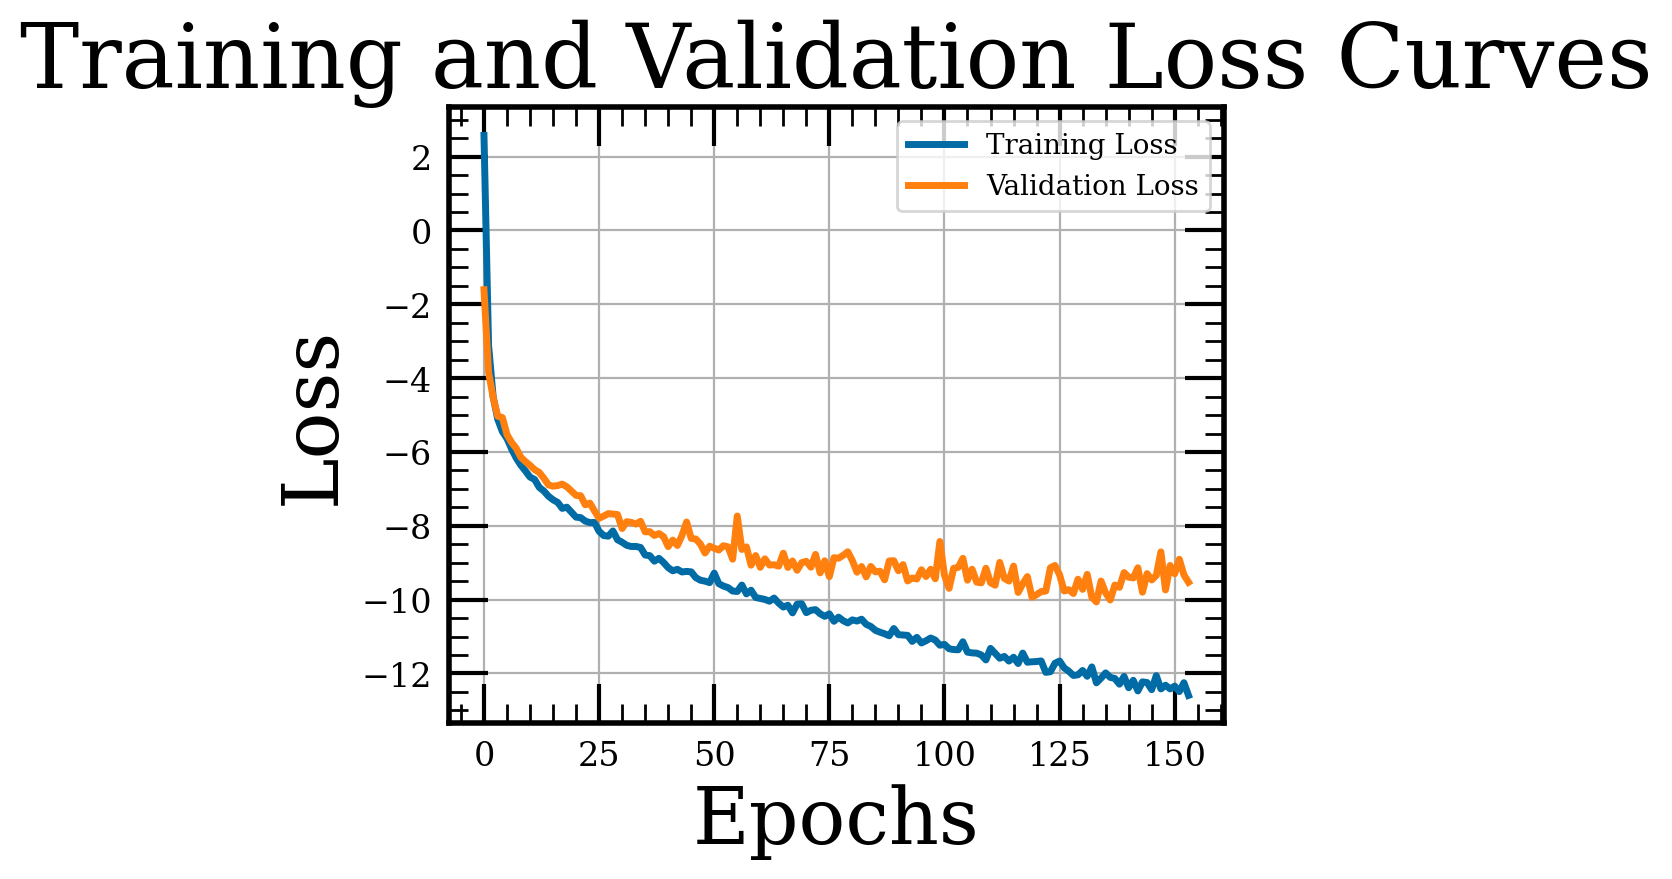

In [7]:
import pickle
dir_sbi = f'../results/results_sbi/sbi{tags_inf[2]}'

fn_inference = f'{dir_sbi}/inference.p'
with open(fn_inference, "rb") as f:
    inference = pickle.load(f)
# Extract training and validation loss
training_loss = inference._summary["training_loss"]
validation_loss = inference._summary["validation_loss"]

# Plot the loss curves
plt.figure(figsize=(5, 4))
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend(fontsize=10)
#plt.ylim(-10.5, -10)
plt.grid(True)

In [8]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_datagen_test_fixed = ''
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test_fixed.shape)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
extents = {**dict_bounds_cosmo, **dict_bounds_bias}

(9,)


In [9]:
tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_datagen_test_fixed + '_mean']*len(tags_inf)

for i, tag_inf in enumerate(tags_inf):
    dir_sbi = f'../results/results_sbi/sbi{tag_inf}'
    tag_test = tags_test[i]
    fn_samples_test_pred = f'{dir_sbi}/samples_test{tag_test}_pred.npy'
    if not Path.exists(Path(fn_samples_test_pred)):
        print(f"fn_samples {fn_samples_test_pred} not found!")

[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000_ntrain500/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000_ntrain1000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000_ntrain2000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000_ntrain4000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000_ntrain6000/samples_test_muchisimoc

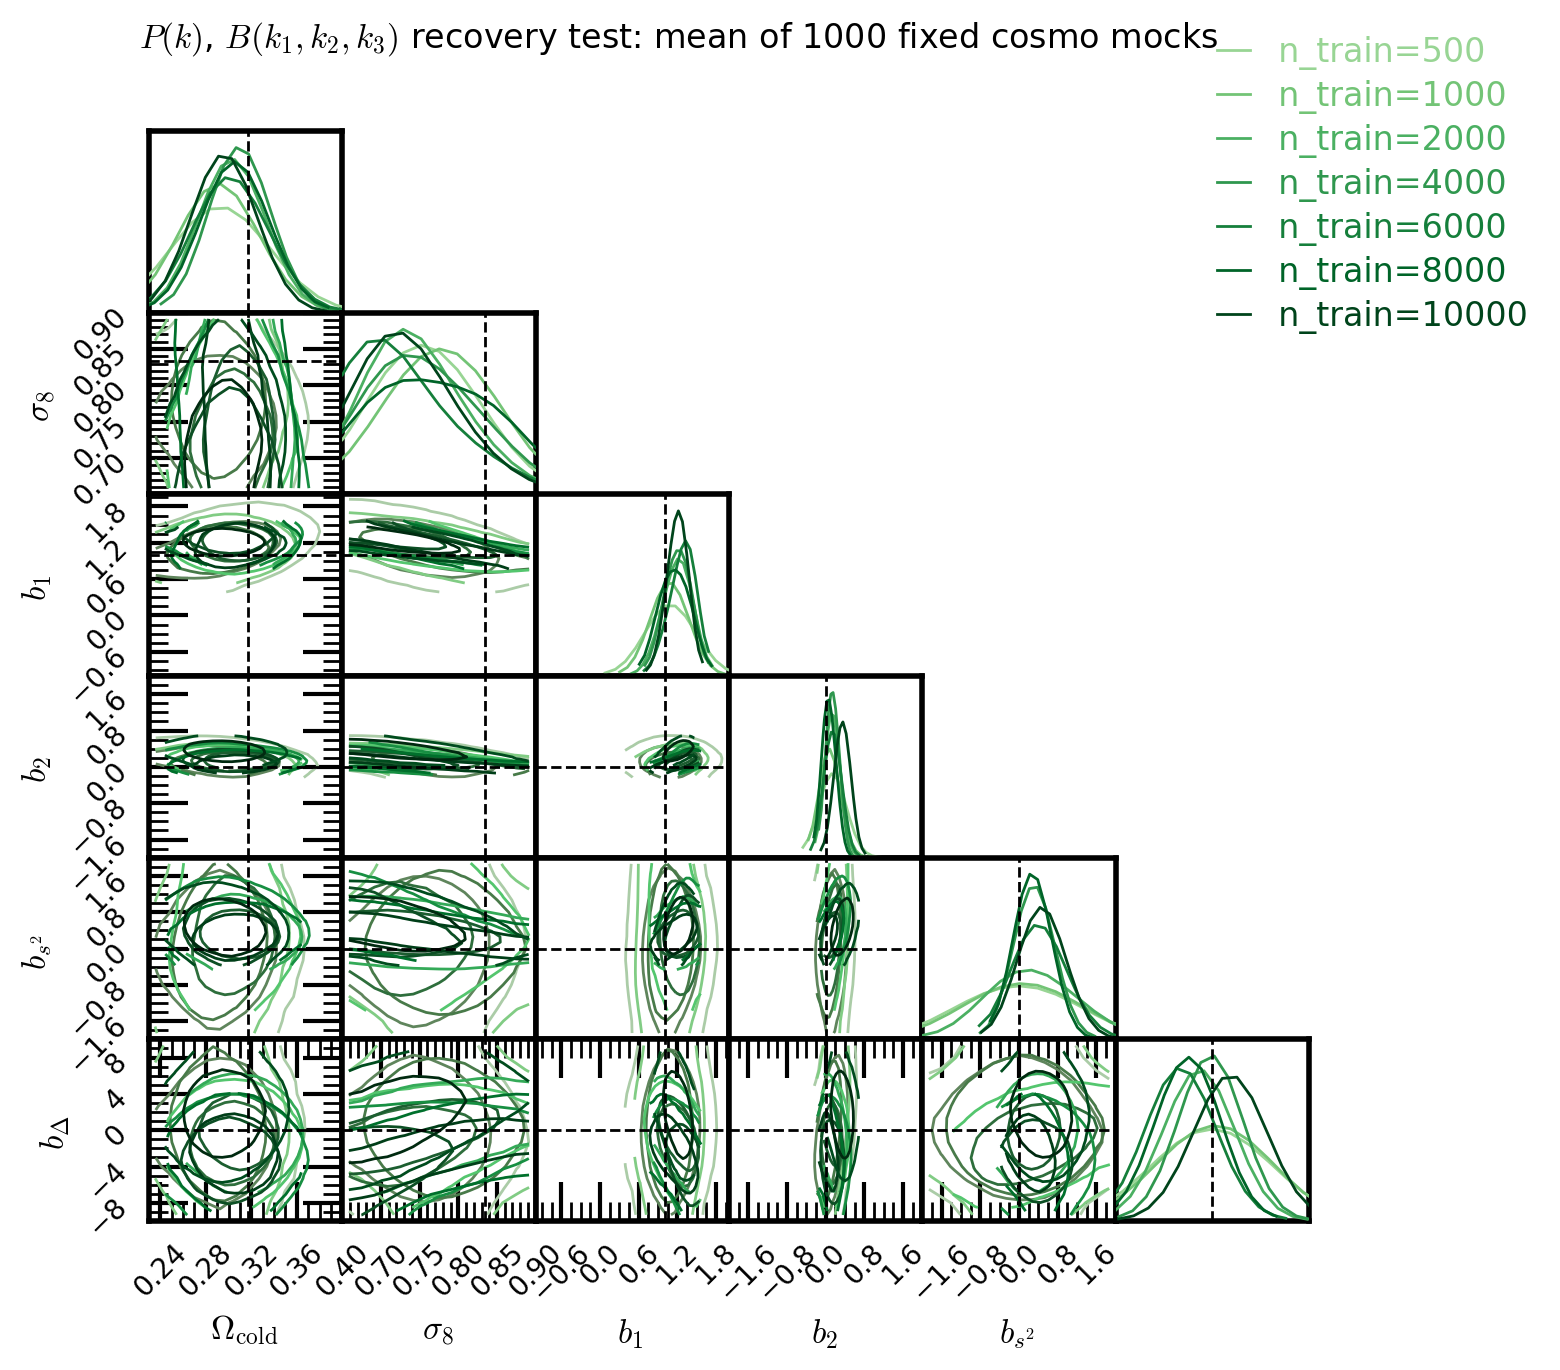

In [10]:
print(theta_test_fixed)
print(param_names_vary)
idx_obs = 0
title = f'{utils.get_stat_label(statistics)} recovery test: mean of 1000 fixed cosmo mocks'
#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_fixed_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]
plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_fixed_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

Get covariances for fixed-cosmo (CV) test

In [11]:
theta_test_pred_fixed_arr, covs_test_pred_fixed_arr = [], []
for i, tag_inf in enumerate(tags_inf):
    theta_test_pred_fixed, covs_test_pred_fixed, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_test[i])
    theta_test_pred_fixed_arr.append(theta_test_pred_fixed[0])
    covs_test_pred_fixed_arr.append(covs_test_pred_fixed[0])
    
theta_test_pred_fixed_arr = np.array(theta_test_pred_fixed_arr)
covs_test_pred_fixed_arr = np.array(covs_test_pred_fixed_arr)
print(theta_test_pred_fixed.shape)
print(theta_test_pred_fixed_arr.shape)
print(covs_test_pred_fixed_arr.shape)

(1, 9)
(7, 9)
(7, 9, 9)


In [12]:
chi2_arr = []
fom_arr = []
for i, tag_inf in enumerate(tags_inf):
    chi2_arr.append(utils.chi2(theta_test_pred_fixed[0], theta_test_pred_fixed_arr[i], covs_test_pred_fixed_arr[i]))
    fom_arr.append(utils.figure_of_merit(covs_test_pred_fixed_arr[i]))
chi2_arr = np.array(chi2_arr)
fom_arr = np.array(fom_arr)

Text(0, 0.5, 'median reduced $\\chi^2$')

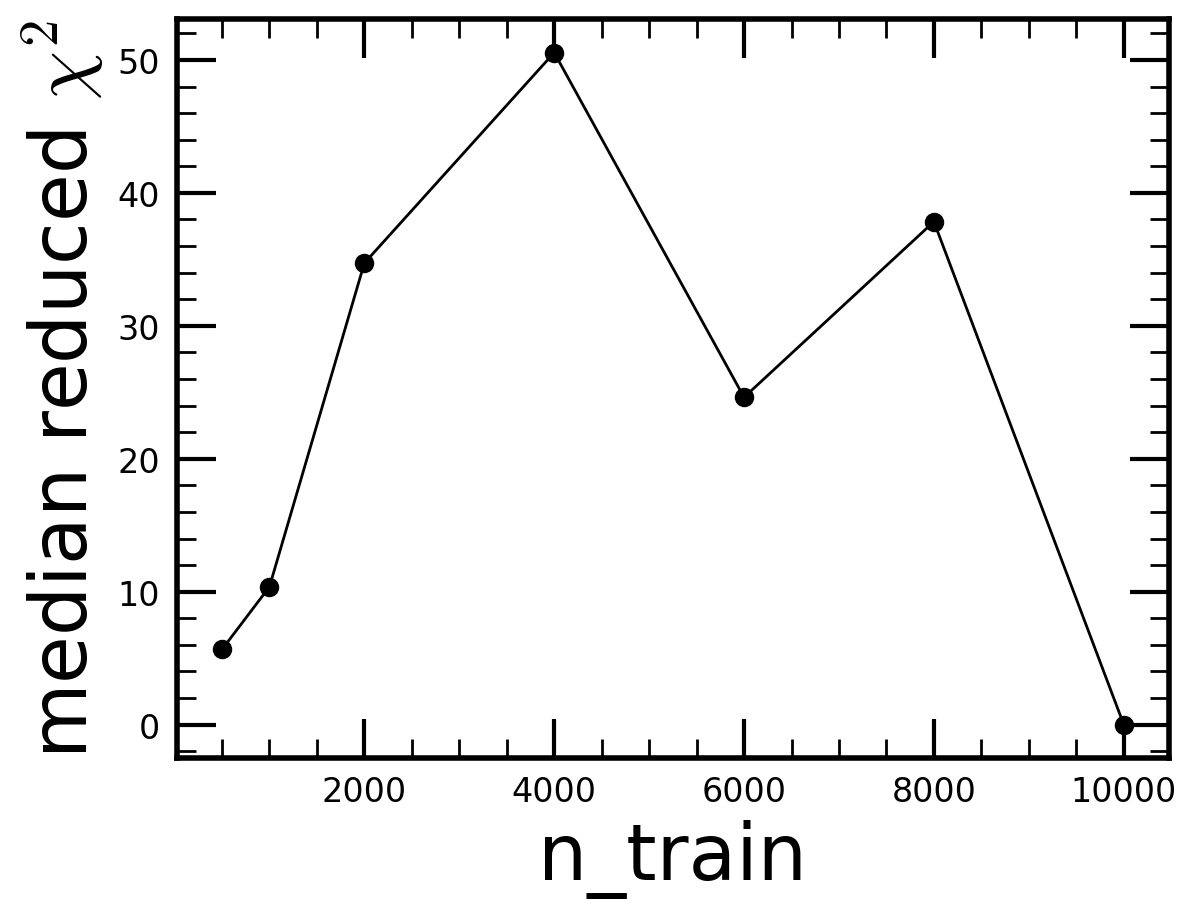

In [13]:
#plt.plot(n_train_arr, chi2_arr/len(param_names_vary), marker='o', lw=1, color='k')
plt.plot(n_train_arr, chi2_arr, marker='o', lw=1, color='k')

plt.xlabel('n_train')
plt.ylabel('median reduced $\chi^2$')

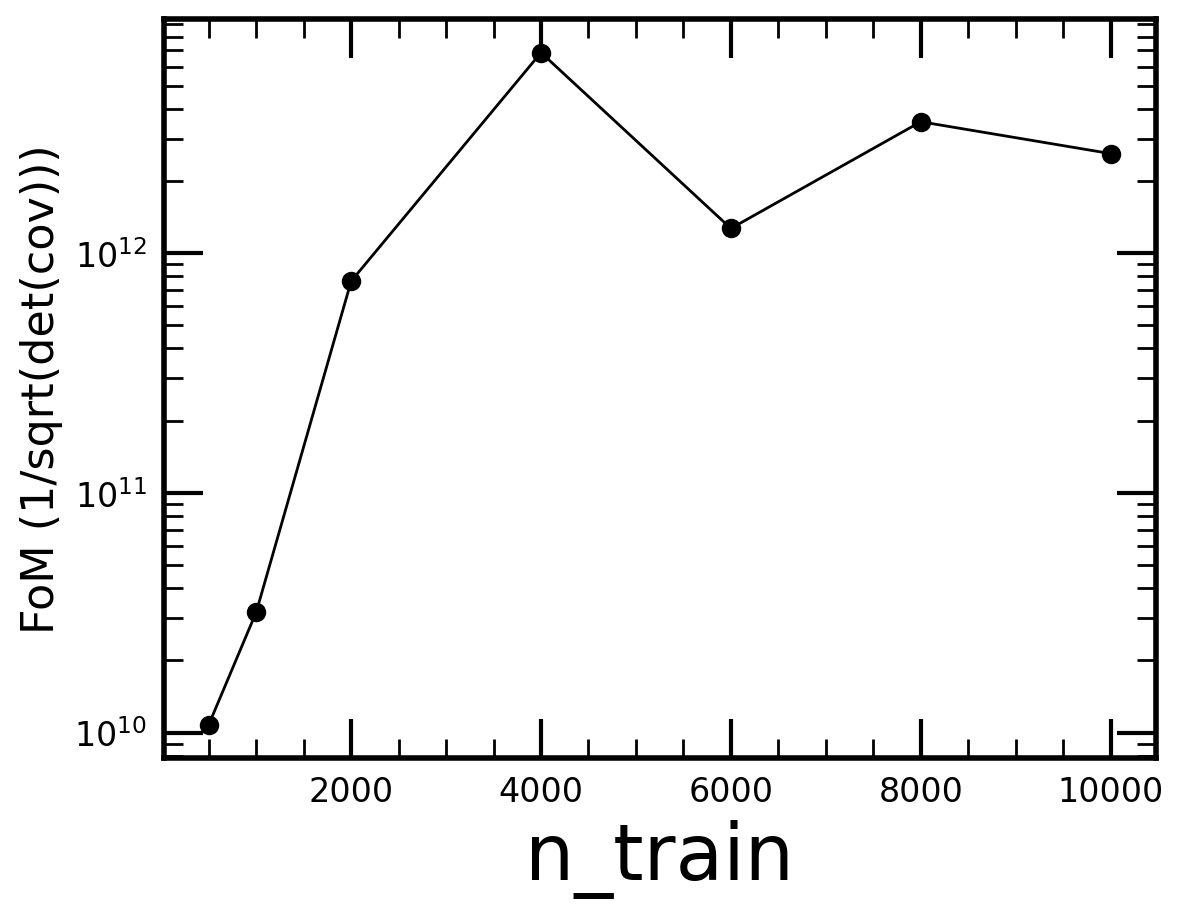

In [14]:
plt.plot(n_train_arr, fom_arr, marker='o', lw=1, color='k')
plt.xlabel('n_train')
plt.ylabel('FoM (1/sqrt(det(cov)))', fontsize=16)
plt.yscale('log')